In [134]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## Data Reading and Preprocessing

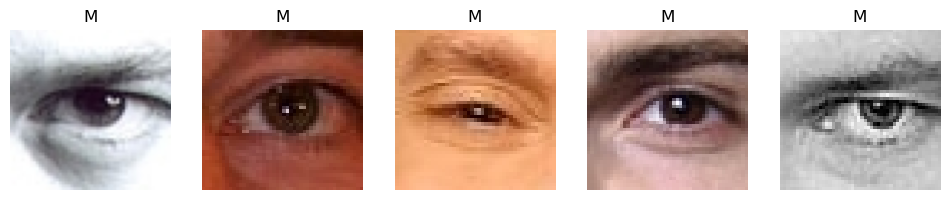

In [2]:
# Reading in data
# Function to read images from a folder and create a DataFrame
def read_images(folder_path, label):
    data = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)  # Read the image
        data.append({"image": img, "label": label})  # Append the image and label to the list
    return data

# Load images and labels from the "maleeyes" folder
maleeyes_folder_path = r"C:\Users\Surya\Desktop\SURYA GEORGIAN\Summer 2023\AIDI 1009 Neural Networks\Assignment 3\archive\maleeyes"
data_maleeyes = read_images(maleeyes_folder_path, "M")

# Load images and labels from the "femaleeyes" folder
femaleeyes_folder_path = r"C:\Users\Surya\Desktop\SURYA GEORGIAN\Summer 2023\AIDI 1009 Neural Networks\Assignment 3\archive\femaleeyes"
data_femaleeyes = read_images(femaleeyes_folder_path, "F")

# Combine the data from both folders into a single DataFrame
data = data_maleeyes + data_femaleeyes
df = pd.DataFrame(data)

# Visualize the images (first 5 images in the DataFrame)
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(df.iloc[i]["image"], cv2.COLOR_BGR2RGB))
    plt.title(df.iloc[i]["label"])
    plt.axis("off")
plt.show()

* Here we are reading images of male and female eyes from two separate folders, creating a Pandas DataFrame to store the image data and labels, and then visualizes the first five images along with their corresponding labels.
* Right now we can see that only males images are being shown as data is combined as male + female

In [3]:
# Shuffling the dataframe to see that we are reading both male and female images 
df = shuffle(df)
df = df.reset_index(drop=True)

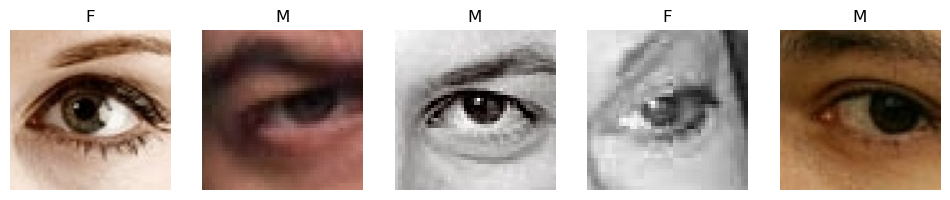

In [4]:
# Visualize the images (first 5 images in the DataFrame)
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(df.iloc[i]["image"], cv2.COLOR_BGR2RGB))
    plt.title(df.iloc[i]["label"])
    plt.axis("off")
plt.show()

* Here we can see that we are able to read in images from both folders and saved them in a dataframe with corresponding labels

In [5]:
#Checking total number of samples
len(df)

11525

* We have 11525 images in total

In [6]:
#checking first 5 rows
df.head()

image label
0  [[[141, 169, 203], [150, 178, 212], [147, 175,...     F
1  [[[64, 76, 116], [74, 86, 128], [83, 94, 138],...     M
2  [[[243, 243, 243], [245, 245, 245], [249, 249,...     M
3  [[[228, 228, 228], [227, 227, 227], [227, 227,...     F
4  [[[47, 79, 108], [37, 69, 98], [29, 57, 91], [...     M

* Here we can see that images are represented as nested lists of pixel values 

In [7]:
# checking the last 5 rows
df.tail()

image label
11520  [[[186, 199, 251], [188, 201, 253], [186, 199,...     F
11521  [[[153, 180, 231], [175, 202, 253], [179, 206,...     M
11522  [[[199, 201, 225], [197, 199, 223], [199, 200,...     M
11523  [[[146, 166, 213], [175, 192, 235], [186, 201,...     M
11524  [[[140, 154, 226], [140, 154, 226], [141, 155,...     M

In [8]:
# checking info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11525 entries, 0 to 11524
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   11525 non-null  object
 1   label   11525 non-null  object
dtypes: object(2)
memory usage: 180.2+ KB


In [11]:
# checking the missing labels or missing values in dataframe
df.isna().sum()

image    0
label    0
dtype: int64

In [9]:
# checking the number of images with "M" labels and "F" labels
# Use value_counts() to count the occurrences of each unique label
label_counts = df["label"].value_counts()

# Print the number of images for each label
print("Number of images with F label:", label_counts["F"])
print("Number of images with M label:", label_counts["M"])

Number of images with F label: 5202
Number of images with M label: 6323


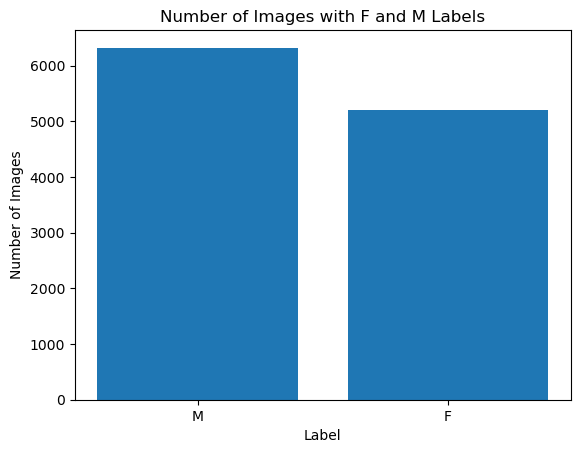

In [10]:
# Create a bar chart
plt.bar(label_counts.index, label_counts.values)

# Add labels and title
plt.xlabel("Label")
plt.ylabel("Number of Images")
plt.title("Number of Images with F and M Labels")

# Show the plot
plt.show()

* Here we can see that there is a difference in number of images with "M" label or males images and images with "F" label or female images

* We can see that the images for males are more than female. so for better model performance, bias prevention and robustness of our models i will balance these classes by randomly choosing the number of images of males equal to the number of images of females

In [12]:
# Balancing the number of images for both labels by downsampling the "M" label images
min_images = min(label_counts)

# Randomly select "M" label images to achieve balance
m_label_indices = df[df["label"] == "M"].index
selected_m_indices = np.random.choice(m_label_indices, min_images, replace=False)

# Get the indices for "F" label images
f_label_indices = df[df["label"] == "F"].index

# Combine the indices of selected "M" label images and "F" label images
balanced_indices = np.concatenate([selected_m_indices, f_label_indices])

# Create the balanced DataFrame
balanced_df = df.loc[balanced_indices]

In [14]:
df = balanced_df

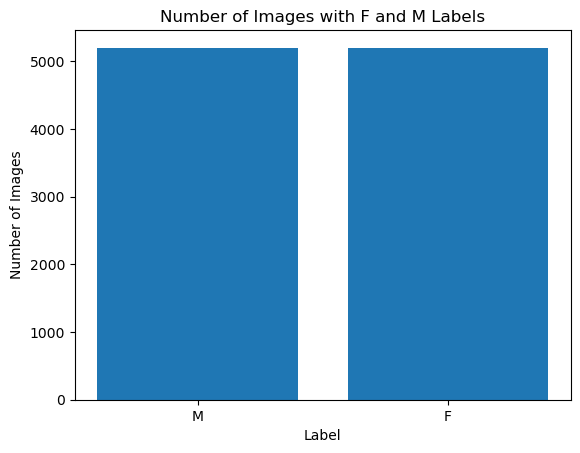

In [15]:
label_counts = df["label"].value_counts()
# Create a bar chart
plt.bar(label_counts.index, label_counts.values)

# Add labels and title
plt.xlabel("Label")
plt.ylabel("Number of Images")
plt.title("Number of Images with F and M Labels")

# Show the plot
plt.show()

* Here we can see that number of males and females images are equal now

In [22]:
# Checking the size of images if there any difference
# Function to check if all images have the same shape
def are_all_images_same_size(image_list):
    first_image_shape = image_list[0].shape
    return all(image.shape == first_image_shape for image in image_list), first_image_shape

# Get the list of all images from the DataFrame
image_list = df["image"].tolist()

# Check if all images have the same shape and get the first image's shape
same_size, first_image_shape = are_all_images_same_size(image_list)

if same_size:
    print("All images have the same size:", first_image_shape)
else:
    print("Some images have different sizes.")

    # Get the highest and smallest image sizes
    max_shape = max(image.shape for image in image_list)
    min_shape = min(image.shape for image in image_list)

    print("Highest image size:", max_shape)
    print("Smallest image size:", min_shape)

# Get the number of unique image shapes
unique_shapes = set(image.shape for image in image_list)

# The number of different sizes of images is the number of unique shapes
different_sizes_of_images = len(unique_shapes)
print("different sizes of images:", different_sizes_of_images)

Some images have different sizes.
Highest image size: (117, 117, 3)
Smallest image size: (41, 41, 3)
different sizes of images: 65


* Here we can see that there are 65 different sizes of images in the dataframe
* There is an image with size of (117,117,3) and there is an image of size (41,41,3)
* Different size of images will become challenging while feeding the data to models so we will be resizing all the images to same size of (64,64,3)
* It will also help in maintaining computation efficiency and avoiding bias.

In [23]:
# Function to resize images to a specific size
def resize_image(image, target_size):
    return cv2.resize(image, target_size)

# Function to convert images to RGB format
def convert_to_rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get the list of all images from the DataFrame
image_list = df["image"].tolist()

# Target size for resizing
target_size = (64, 64)

# Resize all images to the target size
resized_images = [resize_image(image, target_size) for image in image_list]

# Convert all images to RGB format
rgb_images = [convert_to_rgb(image) for image in resized_images]

# Update the "image" column in the DataFrame with the resized and converted images
df["image"] = rgb_images

In [24]:
# Get the shape of the first image in the DataFrame
first_image_shape = df["image"].iloc[0].shape

print("Image size after resizing and converting to RGB:", first_image_shape)

Image size after resizing and converting to RGB: (64, 64, 3)


* Here we can see that all the images are resized to 64,64,3

In [25]:
# Function to flatten the image values
def flatten_image(image):
    return np.array(image).flatten()

# Apply the flattening function to the "image" column
df["image"] = df["image"].apply(flatten_image)
df.head()

image label
503    [173, 156, 138, 173, 156, 140, 173, 155, 141, ...     M
3873   [176, 126, 103, 172, 122, 99, 172, 122, 99, 17...     M
816    [82, 50, 71, 79, 47, 68, 76, 44, 67, 73, 41, 6...     M
6459   [120, 120, 120, 120, 120, 120, 119, 119, 119, ...     M
11217  [199, 138, 107, 197, 136, 105, 203, 141, 108, ...     M

* Flattening the image values is done to convert a multi-dimensional image into a one-dimensional array. This transformation is often necessary because KNN expect one-dimensional feature vectors as inputs. By flattening the image, we can represent it as a simple list of pixel values, making it compatible with KNN. Flattening essentially removes the spatial structure of the image and treats each pixel as an individual feature, enabling us to process the image data.

In [28]:
# Shuffle the data and reset the index
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Now, the data is shuffled, and the index is reset to start from 0
df.head()

image label
0  [92, 54, 43, 121, 79, 68, 152, 106, 91, 177, 1...     F
1  [219, 191, 177, 200, 173, 158, 180, 153, 141, ...     F
2  [224, 174, 149, 222, 172, 147, 219, 172, 144, ...     F
3  [146, 137, 138, 144, 135, 136, 141, 133, 134, ...     M
4  [233, 170, 129, 232, 169, 128, 233, 169, 130, ...     F

* As we had choosen random number of images from male so now we need to reshuffle the data and reset the index to 0

In [30]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the "label" column using the LabelEncoder
df["label"] = label_encoder.fit_transform(df["label"])
df.head()

image  label
0  [92, 54, 43, 121, 79, 68, 152, 106, 91, 177, 1...      0
1  [219, 191, 177, 200, 173, 158, 180, 153, 141, ...      0
2  [224, 174, 149, 222, 172, 147, 219, 172, 144, ...      0
3  [146, 137, 138, 144, 135, 136, 141, 133, 134, ...      1
4  [233, 170, 129, 232, 169, 128, 233, 169, 130, ...      0

* Here we are using label encoder to label the images. We can see that Females are encoded as 0 and males are encoded as 1 

In [34]:
# Split the data into features (X) and labels (y)
X = df["image"].tolist()
y = df["label"].values

# Further split X and y into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_validation, y_test, y_validation = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shape of each set
print("Shape of X_train:", len(X_train))
print("Shape of y_train:", len(y_train))
print("Shape of X_test:", len(X_test))
print("Shape of y_test:", len(y_test))
print("Shape of X_validation:", len(X_validation))
print("Shape of y_validation:", len(y_validation))

Shape of X_train: 8323
Shape of y_train: 8323
Shape of X_test: 1040
Shape of y_test: 1040
Shape of X_validation: 1041
Shape of y_validation: 1041


* First splitting the data into target and feature columns and then splitting it again for train , validation and test data in a 80,10,10 split ratio

## KNN

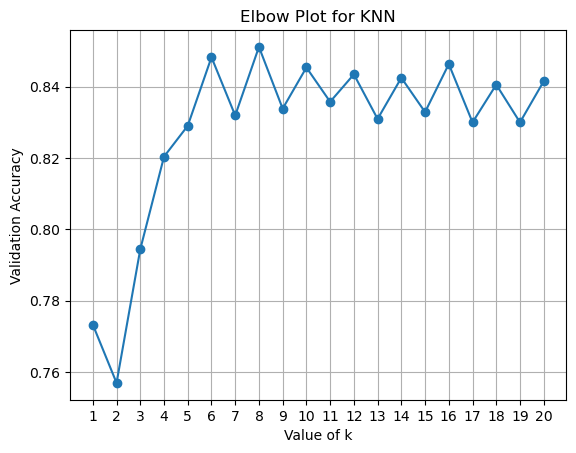

In [37]:
# elbow method to find optimal k value
# Create a range of k values to try
k_values = range(1, 21)

# Initialize lists to store accuracies for different k values
accuracies = []

# Train and evaluate KNN for different k values
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_validation)
    accuracy = accuracy_score(y_validation, y_pred)
    accuracies.append(accuracy)

# Create an elbow plot
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Value of k')
plt.ylabel('Validation Accuracy')
plt.title('Elbow Plot for KNN')
plt.xticks(k_values)
plt.grid(True)
plt.show()

* Here we are using elbow method to find the optimal value of K for KNN. We can see that we are getting the best validation accuracy at value of K as 8 so we will be choosing this as our K value

### fitting and predicting with KNN as k =8

In [40]:
# Create and train the KNN model with k = 8 (the optimal value from the elbow plot)
k = 8
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

# Predict on the validation data
y_validation_pred = knn_model.predict(X_validation)

# Generate and print the classification report for validation data
class_report_validation = classification_report(y_validation, y_validation_pred)
print("Classification Report for Validation Data:")
print(class_report_validation)

# Generate and print the confusion matrix for validation data
conf_matrix_validation = confusion_matrix(y_validation, y_validation_pred)
print("Confusion Matrix for Validation Data:")
print(conf_matrix_validation)

# Predict on the testing data
y_test_pred = knn_model.predict(X_test)

# Generate and print the classification report for testing data
class_report_test = classification_report(y_test, y_test_pred)
print("Classification Report for Testing Data:")
print(class_report_test)

# Generate and print the confusion matrix for testing data
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix for Testing Data:")
print(conf_matrix_test)

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       525
           1       0.83      0.87      0.85       516

    accuracy                           0.85      1041
   macro avg       0.85      0.85      0.85      1041
weighted avg       0.85      0.85      0.85      1041

Confusion Matrix for Validation Data:
[[435  90]
 [ 65 451]]
Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       503
           1       0.84      0.87      0.85       537

    accuracy                           0.84      1040
   macro avg       0.84      0.84      0.84      1040
weighted avg       0.84      0.84      0.84      1040

Confusion Matrix for Testing Data:
[[413  90]
 [ 72 465]]


### Explanation of KNN results

* Precision: Precision measures the accuracy of positive predictions. For class 0, it is 0.85, which means that out of all the samples predicted as class 0, 85% are correct. For class 1, it is 0.84, indicating that 84% of the samples predicted as class 1 are correct.
* Recall: Recall (also called sensitivity) measures the proportion of actual positive samples that are correctly identified by the model. For class 0, it is 0.82, meaning that 82% of the actual class 0 samples are correctly identified. For class 1, it is 0.87, indicating that 87% of the actual class 1 samples are correctly identified.
* F1-score: The F1-score is the harmonic mean of precision and recall and provides a balance between the two metrics. It is often used when classes are imbalanced. The F1-scores for both classes 0 and 1 are around 0.84, indicating a good balance between precision and recall.

#### Confusion matrix
* True Positives (TP): There are 465 samples that belong to class 1 (female) and are correctly predicted as class 1.
* True Negatives (TN): There are 413 samples that belong to class 0 (male) and are correctly predicted as class 0.
* False Positives (FP): There are 90 samples that do not belong to class 1 (female) but are incorrectly predicted as class 1.
* False Negatives (FN): There are 72 samples that belong to class 1 (female) but are incorrectly predicted as class 0.

* the model achieved an accuracy of 84% on the testing data. The precision, recall, and F1-score for each class (male and female) are around 84-85%, indicating a good balance between precision and recall. The macro average F1-score and weighted average F1-score are both around 0.84, which means the model performs reasonably well in classifying both male and female images.

In [45]:
# Convert X_train, y_train, X_test, y_test, X_validation, and y_validation to NumPy arrays
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
X_validation_np = np.array(X_validation)
y_validation_np = np.array(y_validation)

# Print the shapes of the NumPy arrays
print("Shape of X_train:", X_train_np.shape)
print("Shape of y_train:", y_train_np.shape)
print("Shape of X_test:", X_test_np.shape)
print("Shape of y_test:", y_test_np.shape)
print("Shape of X_validation:", X_validation_np.shape)
print("Shape of y_validation:", y_validation_np.shape)

Shape of X_train: (8323, 12288)
Shape of y_train: (8323,)
Shape of X_test: (1040, 12288)
Shape of y_test: (1040,)
Shape of X_validation: (1041, 12288)
Shape of y_validation: (1041,)


* Converting the data to numpy arrays as we can  easily convert them to PyTorch tensors using torch.from_numpy() or torch.tensor(). This makes it easier to work with the data in PyTorch.

In [115]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the training data and transform the data
X_train_scaled = scaler.fit_transform(X_train_numpy)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test_numpy)

# Transform the validation data using the same scaler
X_validation_scaled = scaler.transform(X_validation_np)

* Scaling the data to have a mean of 0 and a standard deviation of 1. This process transforms the features into a more consistent and comparable scale, making the training process more effective and reliable

## MLP

In [125]:
class TrainData(Dataset): #This class is a custom dataset class that inherits from torch.utils.data.Dataset. 
    def __init__(self, X_data, y_data): # initializes the class with the training features (X_data) and labels (y_data).
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index): # method retrieves an item from the dataset based on an index. 
        x = self.X_data[index].numpy()
        y = self.y_data[index].item()
        return x, y

    def __len__(self): #returns the total number of items in the dataset.
        return len(self.X_data)

class TestData(Dataset): # #This class is a custom dataset class that inherits from torch.utils.data.Dataset. 
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        x = self.X_data[index].numpy()
        y = self.y_data[index].item()
        return x, y

    def __len__(self):
        return len(self.X_data)

# Convert the DataFrame to numpy arrays 
X_train_numpy = X_train_scaled.astype(np.float32)
y_train_numpy = y_train_np.astype(np.long)
X_test_numpy = X_test_scaled.astype(np.float32)
y_test_numpy = y_test_np.astype(np.long) 

# Create instances of TrainData and TestData classes
train_data = TrainData(torch.from_numpy(X_train_numpy), torch.from_numpy(y_train_numpy))
test_data = TestData(torch.from_numpy(X_test_numpy), torch.from_numpy(y_test_numpy))

* This code defines custom dataset classes, TrainData and TestData, inheriting from PyTorch's Dataset. It converts DataFrame features and labels to NumPy arrays and creates instances of these classes for training and testing data. These classes facilitate data loading for PyTorch-based ML models.

In [126]:
# the EYNet class represents a neural network model with three fully connected layers and ReLU activation functions. 
# The forward method defines the forward pass computation of the model.
class EYNet(nn.Module): #defines a new class called CreditNet, which is a subclass of nn.Module.
    
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        
        super(EYNet, self).__init__() #This line calls the constructor of the parent class nn.Module to initialize the CreditNet model.
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

* Our model consists of three fully connected layers with ReLU activation functions in between.

In [127]:
# creates an instance of the CreditNet model and then prints the model object. 
model = EYNet(12288, 100, 50, 2)
print(model)

EYNet(
  (fc1): Linear(in_features=12288, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)


In [128]:
# This code  sets the batch size, prints the number of instances in the training and testing/validation sets, 
# and creates data loaders for the training and testing/validation sets. 
batch_size = 500
# How many instances have we got?
print('# instances in training set: ', len(train_data))
print('# instances in testing/validation set: ', len(test_data))

# Create the dataloaders - for training and validation/testing
# We will be using the term validation and testing data interchangably
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
# The data loaders (train_loader and test_loader) enable iterating over the data in batches, 
# which is essential for training and evaluating the neural network model using mini-batch stochastic gradient descent 
# or other optimization algorithms.

# instances in training set:  8323
# instances in testing/validation set:  1040


In [129]:
# Our model
net = EYNet(12288, 100, 50, 2)

# Out loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, nesterov=True, momentum=0.9, dampening=0)  

In [130]:
num_epochs = 150

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    
    train_correct = 0
    train_total = 0
    
    for i, (items, classes) in enumerate(train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items.float())
        classes = Variable(classes.long())
        
        net.train()           # Put the network into training mode
        
        optimizer.zero_grad() # Clear off the gradients from any past operation
        outputs = net(items)  # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        loss.backward()       # Calculate the gradients with help of back propagation
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data
        train_total += classes.size(0)    
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == classes.data).sum()

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.data))

    net.eval()                 # Put the network into evaluation mode
    
    # Book keeping
    # Record the loss
    train_loss.append(loss.data)

    # What was our train accuracy?
    train_accuracy.append((100 * train_correct / train_total))
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    test_items = torch.FloatTensor(test_data.X_data)
    test_classes = torch.LongTensor(test_data.y_data.type(torch.LongTensor))

    outputs = net(Variable(test_items))
    loss = criterion(outputs, Variable(test_classes))
    test_loss.append(loss.data)
    _, predicted = torch.max(outputs.data, 1)
    total = test_classes.size(0)
    correct = (predicted == test_classes).sum()
    test_accuracy.append((100 * correct / total))

Epoch 1/150, Iteration 1/16, Loss: 0.6992
Epoch 1/150, Iteration 2/16, Loss: 0.6952
Epoch 1/150, Iteration 3/16, Loss: 0.6892
Epoch 1/150, Iteration 4/16, Loss: 0.6931
Epoch 1/150, Iteration 5/16, Loss: 0.6865
Epoch 1/150, Iteration 6/16, Loss: 0.6847
Epoch 1/150, Iteration 7/16, Loss: 0.6844
Epoch 1/150, Iteration 8/16, Loss: 0.6838
Epoch 1/150, Iteration 9/16, Loss: 0.6745
Epoch 1/150, Iteration 10/16, Loss: 0.6703
Epoch 1/150, Iteration 11/16, Loss: 0.6656
Epoch 1/150, Iteration 12/16, Loss: 0.6573
Epoch 1/150, Iteration 13/16, Loss: 0.6605
Epoch 1/150, Iteration 14/16, Loss: 0.6528
Epoch 1/150, Iteration 15/16, Loss: 0.6426
Epoch 1/150, Iteration 16/16, Loss: 0.6605
Epoch 1/150, Iteration 17/16, Loss: 0.6484
Epoch 2/150, Iteration 1/16, Loss: 0.6490
Epoch 2/150, Iteration 2/16, Loss: 0.6362
Epoch 2/150, Iteration 3/16, Loss: 0.6376
Epoch 2/150, Iteration 4/16, Loss: 0.6424
Epoch 2/150, Iteration 5/16, Loss: 0.6209
Epoch 2/150, Iteration 6/16, Loss: 0.6222
Epoch 2/150, Iteration 7/1

### Observation
* The training process was successful as indicated by the decreasing loss values over the 150 epochs, demonstrating that the model is learning and fitting to the training data.

* The final loss value of 0.0209 suggests that the model achieved a low training error, which is a positive sign for its ability to make accurate predictions on the training data.

* However, without validation or test set results, it is difficult to assess the model's generalization performance. Overfitting is a potential concern, where the model might have memorized the training data but may not perform well on new, unseen data.

* To draw more robust conclusions, evaluating the model on a separate validation or test set is crucial to understand its performance on unseen data and address possible overfitting issues.

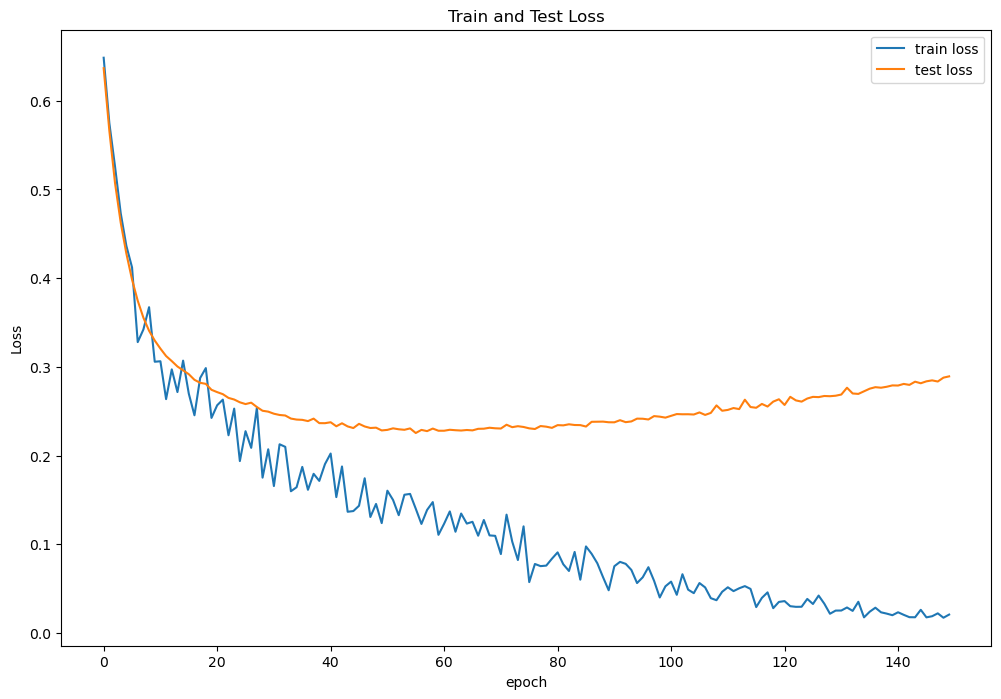

In [131]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
plt.legend()
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

### Observation:

The training loss consistently decreases throughout the training process, indicating that the model is effectively learning from the training data and fitting to it.

However, the test loss reaches its lowest point around the 40th epoch and starts increasing after that, which suggests that the model's performance on the test data begins to degrade as the number of epochs increases.

### Reasoning:

The continuous decrease in training loss demonstrates that the model is becoming increasingly specialized in predicting the training data, which could lead to overfitting. Overfitting occurs when the model performs well on the training data but fails to generalize to unseen data.

The increasing test loss after the 40th epoch indicates that the model is starting to lose its ability to generalize to new data. It becomes overly tailored to the specific patterns and noise present in the training set, making it less capable of making accurate predictions on unseen examples.


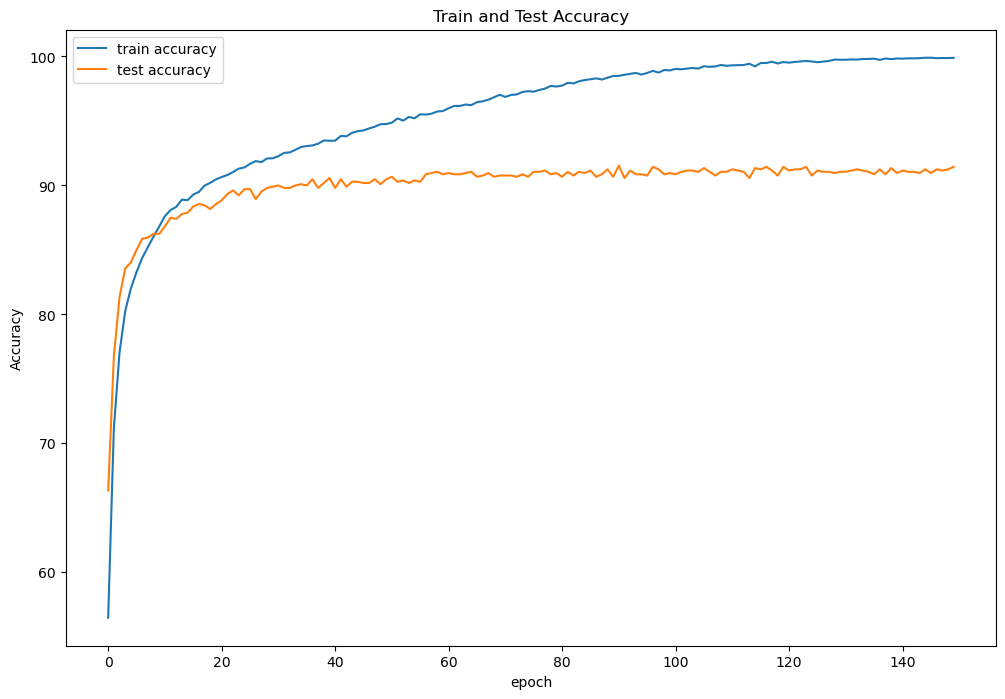

In [132]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.show()

### Observation:
The training accuracy keeps increasing as the number of epochs increases, while the test accuracy becomes stable after the 40th epoch and does not show significant improvement.

### Reasoning:
This behavior indicates that the model is effectively learning from the training data and fitting well to it. However, the lack of significant improvement in test accuracy after the 40th epoch suggests that the model may be starting to overfit.

Initially, as the model trains on the training data, it learns to capture the underlying patterns and features present in the data, leading to an increase in training accuracy. However, after a certain point, the model may start memorizing the training data rather than generalizing to new, unseen data. This overfitting phenomenon leads to a plateau in test accuracy, as the model's performance on the test data does not improve despite more training.

## How can we fix these issues. -------> L1/L2 regularization, Early Stopping, Dropout

So in our case we are observing that test accuracy became stable after 40th epoch and test loss started to increase after 40th epoch. So the most suitable strategy will be early stopping.

### Intuition behing using Early stopping.

* L2 Regularization: L2 regularization can help prevent overfitting by adding a penalty term to the loss function, discouraging large weight values. While it may help to some extent, it may not be sufficient to address the specific issue observed in our results. L2 regularization might be more effective when there is evidence of significant overfitting due to large weights.

* Dropout: Dropout is a regularization technique that randomly deactivates neurons during training. But our results may not be solely due to over-reliance on specific neurons, so dropout might not be the most effective solution.

* Early Stopping: Early stopping is a technique where training is stopped when the model's performance on the validation set (test set in this case) does not improve or starts to degrade. Since the test loss stops decreasing and the test accuracy becomes stable after the 40th epoch, it suggests that the model is overfitting to the training data. Early stopping can help prevent further overfitting and allow the model to generalize better to unseen data.

### Code for early stopping
#### I havent used this code in the project its just for refrence for implementation

num_epochs = 150
early_stopping_patience = 10
best_validation_loss = float('inf')
best_model_state = None
no_improvement_count = 0

for epoch in range(num_epochs):
    train_correct = 0
    train_total = 0
    train_loss = 0

    for i, (items, classes) in enumerate(train_loader):
        items = Variable(items.float())
        classes = Variable(classes.long())
        
        net.train()
        optimizer.zero_grad()
        outputs = net(items)
        loss = criterion(outputs, classes)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.data
        _, predicted = torch.max(outputs.data, 1)
        train_total += classes.size(0)
        train_correct += (predicted == classes.data).sum()

    net.eval()
    validation_loss = 0

    with torch.no_grad():
        for items, classes in validation_loader:
            items = Variable(items.float())
            classes = Variable(classes.long())
            outputs = net(items)
            loss = criterion(outputs, classes)
            validation_loss += loss.data

    # Calculate validation loss
    validation_loss /= len(validation_loader)

    # Check for improvement in validation loss
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        best_model_state = net.state_dict()
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # Early stopping condition
    if no_improvement_count >= early_stopping_patience:
        print("Early stopping! No improvement in validation loss for", early_stopping_patience, "epochs.")
        break

              precision    recall  f1-score   support

     Class 0       0.91      0.91      0.91       503
     Class 1       0.92      0.92      0.92       537

    accuracy                           0.91      1040
   macro avg       0.91      0.91      0.91      1040
weighted avg       0.91      0.91      0.91      1040



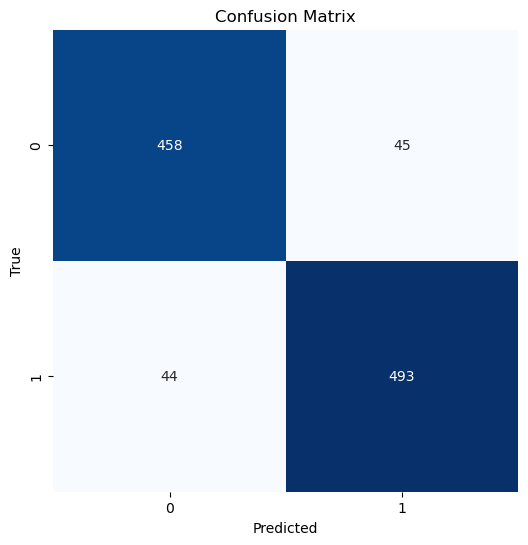

In [135]:
# After the training loop, evaluate the model on the test data
net.eval()  # Put the model in evaluation mode
test_items = torch.FloatTensor(X_test_scaled)  
outputs = net(test_items)
_, predicted_classes = torch.max(outputs.data, 1)  # Get the predicted class indices

# Convert the predicted_classes from torch tensor to numpy array
predicted_classes = predicted_classes.numpy()

num_classes = 2 
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_test, predicted_classes, target_names=target_names))

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Observations:

Precision: For Class 0 (Negative class), the precision is 0.91, which means 91% of the instances predicted as Class 0 are actually Class 0. For Class 1 (Positive class), the precision is 0.92, indicating that 92% of the instances predicted as Class 1 are indeed Class 1.

Recall: The recall for Class 0 is 0.91, meaning that the model correctly identifies 91% of the actual instances of Class 0. For Class 1, the recall is 0.92, indicating that the model can accurately detect 92% of the actual instances of Class 1.

F1-score: The F1-score is a harmonic mean of precision and recall and provides a balanced evaluation metric. For both Class 0 and Class 1, the F1-score is around 0.91-0.92, which indicates a good balance between precision and recall.

Accuracy: The overall accuracy of the model is 91%, which is the percentage of correctly classified instances out of the total instances.

### Reasoning:

The classification report and confusion matrix show that the model performs well in distinguishing between Class 0 and Class 1. The high precision, recall, and F1-score values suggest that the model is effective in making correct predictions for both classes. The accuracy of 91% indicates that the model is providing accurate results for the majority of instances.

The confusion matrix shows that the model misclassified 45 instances of Class 0 as Class 1 (false positives) and 44 instances of Class 1 as Class 0 (false negatives). Despite these misclassifications, the overall performance of the model is quite good, with a balanced trade-off between precision and recall for both classes.


In [146]:
# Plotting the images with predicted an true labels
def map_class_label(class_label):
    return f"Class {class_label}"
def plot_images_with_labels(images, predicted_labels, true_labels, class_mapping=None):
    num_images = len(images)
    num_rows = 20
    num_cols = 5
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 60),
                             gridspec_kw={'hspace': 0.3, 'wspace': 0.2})  # Adjust the spacing between subplots
    
    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            if idx < num_images:
                image = images[idx].reshape(64, 64, 3)  # Reshape the 1D image array back to 64x64x3
                axes[i, j].imshow(image)
                
                if class_mapping:
                    predicted_label = class_mapping[predicted_labels[idx]]
                    true_label = class_mapping[true_labels[idx]]
                else:
                    predicted_label = predicted_labels[idx]
                    true_label = true_labels[idx]
                    
                axes[i, j].set_title(f"Predicted: {predicted_label}\nTrue: {true_label}",
                                     fontsize=10, pad=5)  # Adjust the fontsize and pad for the title
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')
                
    plt.show()

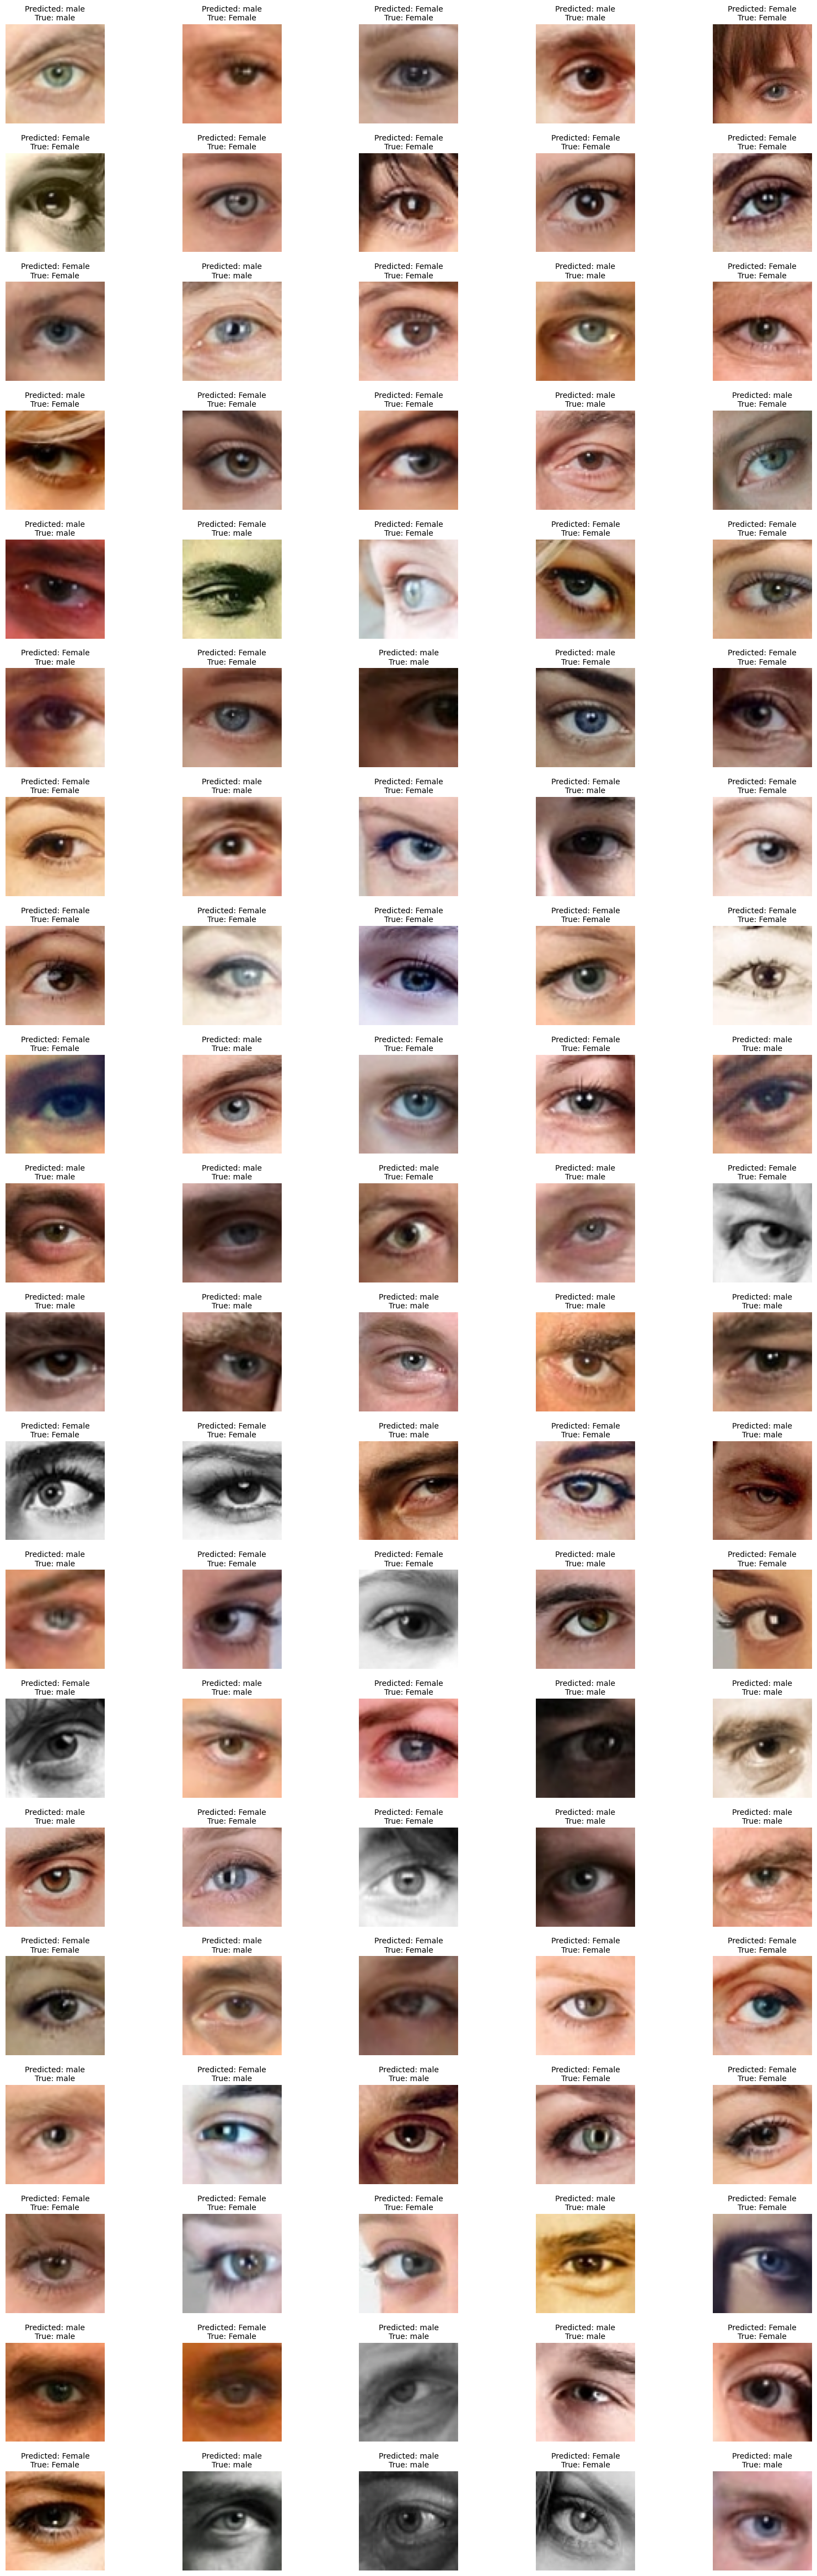

In [148]:
test_classes = torch.LongTensor(y_test)
# Convert the predicted_classes and true class labels to numpy arrays
predicted_classes = predicted_classes
true_labels = y_test

# Map class labels to meaningful names 
class_mapping = {0: "Female", 1: "male"}  
# Plot the images along with their predicted and true class labels
num_images_to_plot = 100  
plot_images_with_labels(X_test[:num_images_to_plot], predicted_classes[:num_images_to_plot], true_labels[:num_images_to_plot], class_mapping)

* Here we can see that what was predicted by our model and what was the real class of that image for first hundred images in test set

## CNN

In [68]:
# normalizing the pixel values of the images to a range between 0 and 1.
x_train = X_train_np/255

y_train = y_train_np

x_test= X_test_np/255

y_test=y_test_np

x_validation= X_validation_np/255

y_validation=y_validation_np

In [71]:
image_rows = 64
image_cols = 64
batch_size = 4096
image_shape = (image_rows,image_cols,3) 

In [74]:
x_train = x_train.reshape(x_train.shape[0],*image_shape)
x_test = x_test.reshape(x_test.shape[0],*image_shape)
x_validate = x_validation.reshape(x_validation.shape[0],*image_shape)

* * By performing this reshaping, we are converting the 1D flattened image data into a 4D tensor where each sample is represented as a 3-dimensional image with dimensions (image_rows, image_cols, 3). This 4D tensor is what our CNN expects as input, allowing us to train the model using these images.

In [81]:
cnn_model = Sequential([
    Conv2D(filters=32,kernel_size=3,activation='relu',input_shape = image_shape),
    MaxPooling2D(pool_size=2) ,# down sampling the output instead of 28*28 it is 14*14
    Dropout(0.2),
    Flatten(), # flatten out the layers
    Dense(32,activation='relu'),
    Dense(2,activation = 'softmax')
    
])

* this CNN model is designed for binary image classification, with 2 output classes. It uses the ReLU activation function for hidden layers and softmax activation for the output layer. The model is capable of distinguishing between two classes, making it suitable for tasks where there are only two possible categories for each image.

In [82]:
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])

In [83]:
history = cnn_model.fit(
    x_train,
    y_train,
    batch_size=4096,
    epochs=75,
    verbose=1,
    validation_data=(x_validate,y_validation),
)

Epoch 1/75
3/3 [==============================] - 22s 5s/step - loss: 2.2019 - accuracy: 0.4945 - val_loss: 0.6932 - val_accuracy: 0.4957
Epoch 2/75
3/3 [==============================] - 18s 5s/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.4957
Epoch 3/75
3/3 [==============================] - 17s 5s/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.4957
Epoch 4/75
3/3 [==============================] - 18s 5s/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.4957
Epoch 5/75
3/3 [==============================] - 18s 5s/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.4957
Epoch 6/75
3/3 [==============================] - 18s 5s/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.4957
Epoch 7/75
3/3 [==============================] - 18s 5s/step - loss: 0.6931 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.4957
Epoch 8/75
3/3 [==================

### Observation and reasoning 
* The training loss decreases, and the accuracy increases with each epoch, indicating that the model is learning to fit the training data well.
* The validation loss decreases, and the accuracy increases initially, showing that the model generalizes well to the validation data. The validation accuracy reaches around 0.87, indicating decent performance.

Text(0.5, 1.0, 'Train - Accuracy')

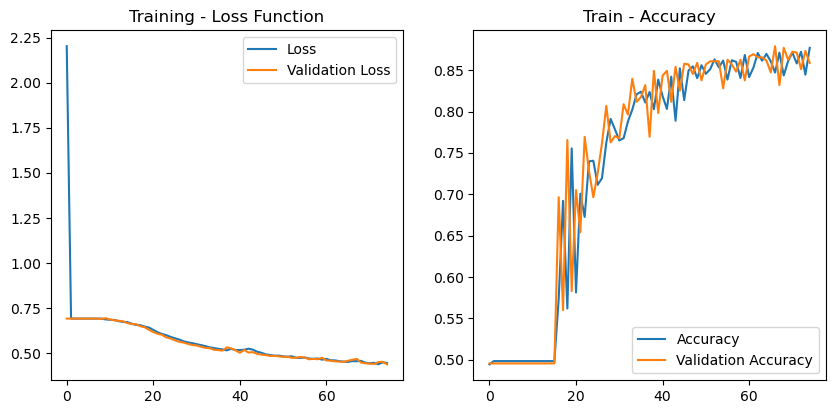

In [84]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [85]:
score = cnn_model.evaluate(x_test,y_test,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Loss : 0.4231
Test Accuracy : 0.8692


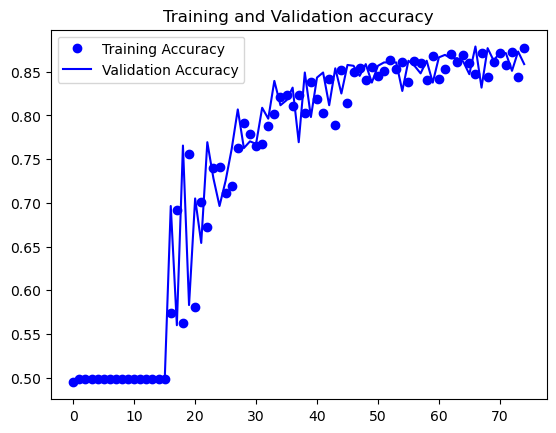

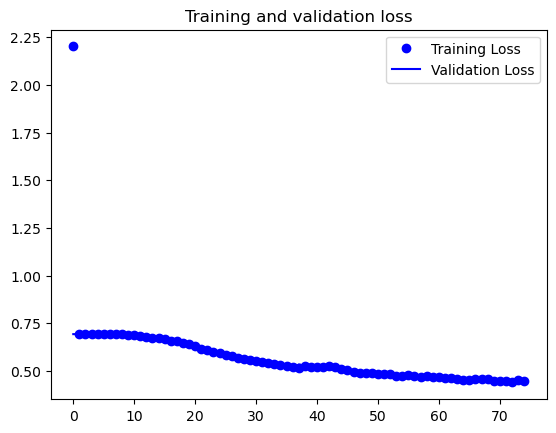

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Observation and reasonings for the plots

#### Training and validation loss
* Both the training and validation loss consistently decrease with each epoch, indicating that the model is learning and improving over time.
* The validation loss overlaps with the training loss most of the time, suggesting that the model generalizes well to unseen data (validation set) and performs similarly to what it learned during training.
* The overlapping trends between training and validation loss indicate that the model does not suffer from significant overfitting. It means that the model is not merely memorizing the training data but is able to generalize well to new, unseen examples.
*  The consistent decrease in both training and validation loss indicates that the model is steadily learning from the data. The decreasing loss signifies that the model is becoming better at making predictions and reducing the errors.

#### Training and validation accuracy
* Both the training and validation accuracy show a continuous increase with each epoch, which indicates that the model is progressively improving its ability to make correct predictions.
*  The validation accuracy overlaps with the training accuracy most of the time, but there are small zigzag lines in the overlapping region, suggesting slight fluctuations in the validation accuracy during training.
*  The increasing training accuracy indicates that the model is learning and adapting to the training data, making fewer mistakes as training progresses.
* The overlapping trends between training and validation accuracy indicate that the model generalizes well to the validation data. It means the model is not overfitting, and the accuracy achieved on the training data is transferable to unseen data.

In [94]:
# Printing classification report
from sklearn.metrics import classification_report

# Get the predictions for the test data
predicted_classes = cnn_model.predict(x_test)

33/33 [==============================] - 0s 11ms/step


In [101]:
# As our last layer is softmax our model is giving output as probailities so taking the max probability 
predicted_classes = np.argmax(predicted_classes, axis=1)

In [102]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.92      0.80      0.86       503
     Class 1       0.83      0.93      0.88       537

    accuracy                           0.87      1040
   macro avg       0.88      0.87      0.87      1040
weighted avg       0.87      0.87      0.87      1040



### Observation and reasoning
* Precision: For Class 0, the precision is 0.92, which means that 92% of the samples predicted as Class 0 were actually true positives. For Class 1, the precision is 0.83, indicating that 83% of the samples predicted as Class 1 were actually true positives. Higher precision indicates a lower number of false positives.

* Recall: For Class 0, the recall is 0.80, which means that 80% of the true Class 0 samples were correctly identified by the model. For Class 1, the recall is 0.93, indicating that 93% of the true Class 1 samples were correctly identified by the model. Higher recall indicates a lower number of false negatives.

* F1-Score: The F1-score is the harmonic mean of precision and recall and provides a balanced measure of the model's performance. For Class 0, the F1-score is 0.86, and for Class 1, the F1-score is 0.88.

* The overall accuracy of the model is 0.87, which means that the model correctly predicts the class label for approximately 87% of the samples.

* The F1-scores for both classes are relatively high, indicating a good balance between precision and recall. This suggests that the model performs well in identifying both Class 0 and Class 1 samples.

* Class 1 has a higher recall (0.93) compared to Class 0 (0.80), which means that the model is better at identifying true positive samples for Class 1. This could be due to Class 1 having more distinct features or being better represented in the training data.

* Class 0 has a higher precision (0.92) compared to Class 1 (0.83), indicating that when the model predicts a sample as Class 0, it is more likely to be correct. This suggests that the model is more certain when predicting Class 0 samples.

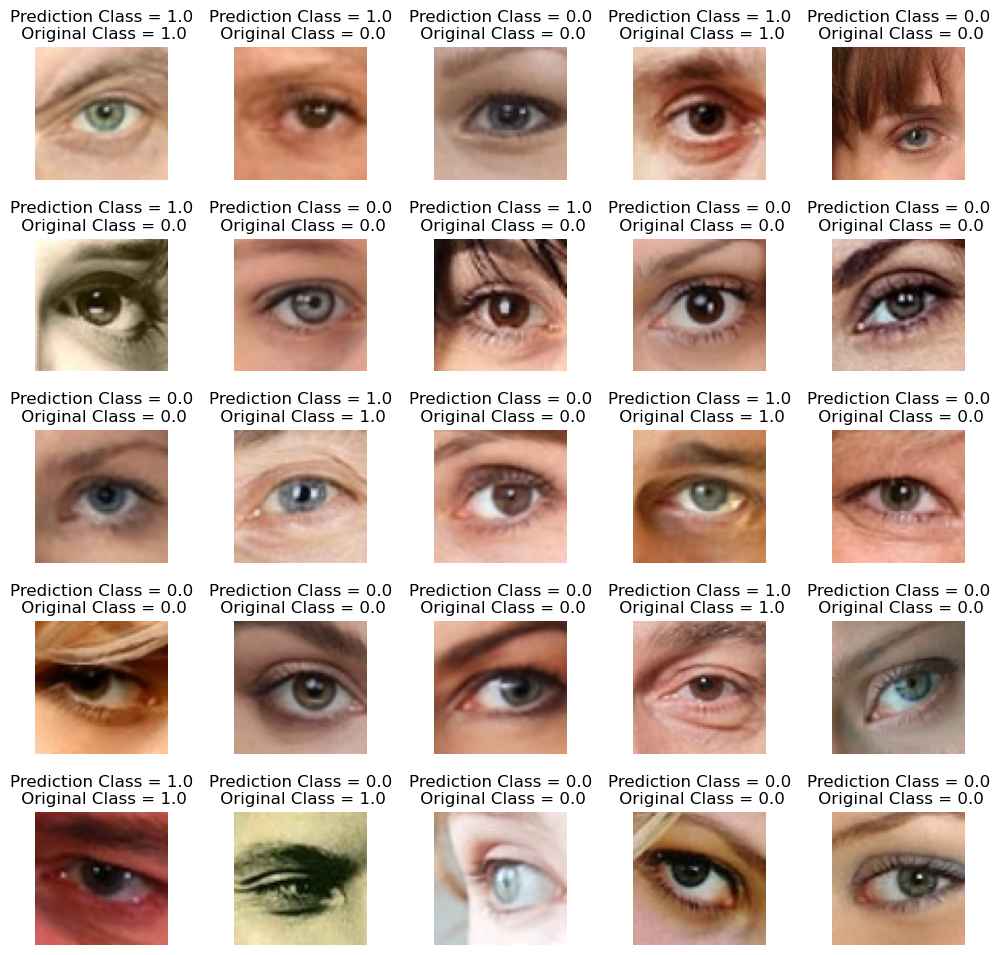

In [105]:
# Printing the images with predicted labels and their true labels
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(x_test[i].reshape(64,64,3))
    axes[i].set_title(f"Prediction Class = {predicted_classes[i]:0.1f}\n Original Class = {y_test[i]:0.1f}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

## Conclusion

### All 3 Model comparison
KNN:
Precision: Class 0 - 0.85, Class 1 - 0.84
Recall: Class 0 - 0.82, Class 1 - 0.87
F1-score: Class 0 - 0.84, Class 1 - 0.85
Accuracy: 0.84
Macro Avg F1-score: 0.84
Weighted Avg F1-score: 0.84

MLP using PyTorch:
Precision: Class 0 - 0.91, Class 1 - 0.92
Recall: Class 0 - 0.91, Class 1 - 0.92
F1-score: Class 0 - 0.91, Class 1 - 0.92
Accuracy: 0.91
Macro Avg F1-score: 0.91
Weighted Avg F1-score: 0.91

CNN using Keras:
Precision: Class 0 - 0.92, Class 1 - 0.83
Recall: Class 0 - 0.80, Class 1 - 0.93
F1-score: Class 0 - 0.86, Class 1 - 0.88
Accuracy: 0.87
Macro Avg F1-score: 0.87
Weighted Avg F1-score: 0.87

Accuracy:
MLP (0.91) and CNN (0.87) both outperform KNN (0.84) in terms of overall accuracy.

Precision and Recall:
MLP and CNN generally show higher precision and recall for both classes compared to KNN.
KNN has similar precision for both classes, but MLP and CNN have slightly higher precision for Class 1.
MLP and CNN have higher recall for Class 1, indicating their ability to better identify positive instances.

F1-score:
MLP and CNN have a higher F1-score for both classes, indicating a better balance between precision and recall.
KNN has reasonably good F1-scores but lags slightly behind MLP and CNN.

Macro Avg F1-score:
MLP and CNN have identical macro average F1-scores of 0.91, showing a consistent performance across classes.
KNN has a slightly lower macro average F1-score of 0.84.

Weighted Avg F1-score:
MLP and CNN have a higher weighted average F1-score of 0.91 compared to KNN's score of 0.84.

Overall, MLP using PyTorch and CNN using Keras both outperform KNN in terms of accuracy, precision, recall, and F1-scores. Between MLP and CNN, their performances are very close, but MLP shows slightly better accuracy and F1-scores, while CNN demonstrates higher recall for Class 1.

#### MLP using PyTorch:
* While the model exhibits good performance with an accuracy of 0.91 and high precision and recall, the loss and accuracy plots indicate signs of overfitting.
* Overfitting is suggested by the increasing gap between training and validation accuracy as the number of epochs increases. This indicates that the model is likely memorizing the training data rather than generalizing well to unseen data.
* The training accuracy continues to increase, but the validation accuracy starts to plateau or even slightly decreases after a certain number of epochs, which is a classic sign of overfitting.
* To mitigate overfitting, techniques like dropout, regularization, or early stopping could be applied during training to achieve better generalization.

#### CNN using Keras:

* The CNN model shows promising results with an accuracy of 0.87, but the loss and accuracy plots suggest that the model could potentially achieve even better accuracy with further training.
* The validation loss and accuracy seem to be converging with the training loss and accuracy, indicating that the model has not yet reached its optimal performance.
* By training the CNN for more epochs, it may be possible to fine-tune the model and allow it to learn more complex patterns from the data, leading to improved accuracy and better generalization.
* However, it's crucial to monitor the validation loss and accuracy during extended training to ensure that the model does not start overfitting.

### Conclusion:
* In our specific case, the CNN model shows promise with an accuracy of 0.87 and provides better performance than KNN and MLP in terms of accuracy, precision, recall, and F1-scores. While the MLP model demonstrates good performance, it indicates signs of overfitting. To address this, techniques like dropout and regularization can be applied during training.

* For the CNN model, the potential for achieving even higher accuracy is evident from the loss and accuracy plots. Training the CNN for more epochs with careful monitoring of validation metrics could lead to better generalization and improved accuracy.

* Considering these factors, the CNN model using Keras seems to be the most suitable choice for our specific case, given its current performance and potential for further optimization. However, it is essential to be cautious about overfitting and ensure that the model is well-tuned to achieve the best results on unseen data.